<a href="https://colab.research.google.com/github/jrakhshanda/Time-Series-Sequence-Learning/blob/master/tssl_lab1_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [58]:
import pandas as pd # Loading data / handling data frames
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
import sklearn.metrics as metrics
from sklearn.neural_network import MLPRegressor # Used for NAR model
from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

In [59]:
df = pd.read_csv("sealevel.csv")
df.head()

,Altimeter type,Merged file cycle nr,Year,Nr observations,Weighted nr observations,GMSL,GMSL std,GMSL smooth,GIA,GIA std,GIA smooth,GIA smooth cycle removed
0,0.0,11.0,1993.011526,466462.0,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889.0,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123.0,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377.0,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548.0,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44


In [60]:
df.shape

(997, 12)

**A1**:
There are 997 observation in the sealevel datset. This datset has 12 features(columns).

### Time-Series Plot of GMSL

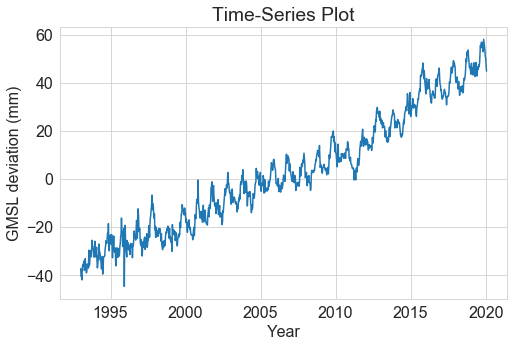

In [61]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 16})
plt.plot(df['Year'],df['GMSL'])
plt.ylabel('GMSL deviation (mm)')
plt.xlabel("Year")
plt.title("Time-Series Plot")
plt.grid(True)
plt.show()

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** In time series, to make our model work well we should have stationary data and to make our data stationary we perform different transofrmation to remove the trend of the data. One of the method to remove trend is the differential method.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

In [62]:
import itertools
model = lm.LinearRegression()
X = df['Year'].values.reshape(-1, 1)
y = df['GMSL'].values.reshape(-1, 1)
model = model.fit( X,y)
y_pred = model.predict(X)
dev = list(itertools.chain.from_iterable(y-y_pred))
mse_reg = np.sum((y-y_pred)**2)/y.shape[0]
print("Mean Square Error of Regression model:", mse_reg)

Mean Square Error of Regression model: 32.29301448925004


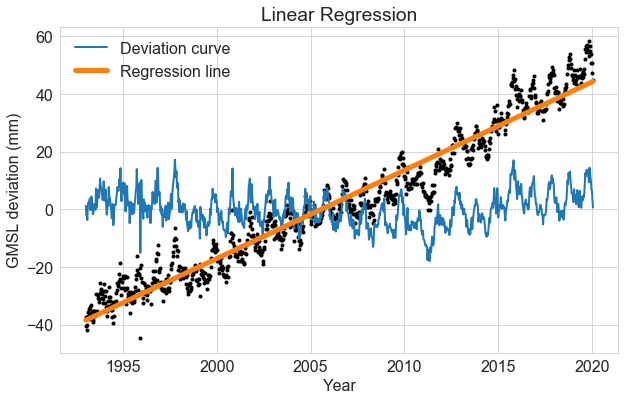

In [63]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(X, y,  color='black', marker=".")
ax.plot(X, dev, linewidth=2, label = 'Deviation curve')
ax.plot(X, y_pred, linewidth=5, label = 'Regression line')
plt.ylabel('GMSL deviation (mm)')
plt.xlabel("Year")
plt.title("Linear Regression")
ax.legend(loc='upper left', frameon=False)
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**


In [64]:
d = {'Year': df['Year'], 'GMSL': dev}
data = pd.DataFrame(data=d)

In [65]:
train, test = data.iloc[0:700,], data.iloc[700:,]
X_train, y_train = train['Year'], train['GMSL']
X_test,y_test = test['Year'], test['GMSL']

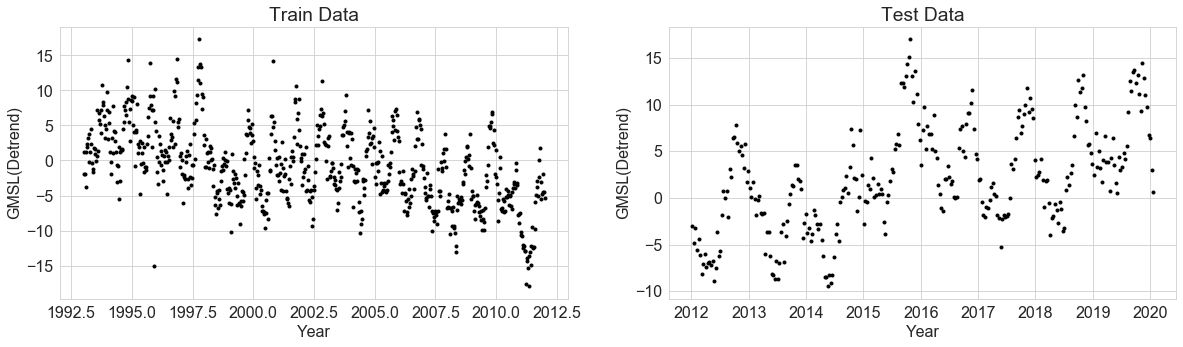

In [66]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train,  color='black', marker=".")
plt.ylabel("GMSL(Detrend)")
plt.xlabel("Year")
plt.title("Train Data")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test,  color='black', marker=".")
plt.ylabel("GMSL(Detrend)")
plt.xlabel("Year")
plt.title("Test Data")
plt.show()

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [67]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = train.shape[0]       # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p)) # <COMPLETE THIS LINE>
    for i in range(p):
        Phi[:,i] = y.loc[i:n+i-p-1] # <COMPLETE THIS LINE>
    #Phi = Phi[::-1]
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_,Phi

In [68]:
theta,Phi = fit_ar(y_train,10)
print("Regression Coefficients:",theta)

Regression Coefficients: [ 0.02305208 -0.11175939  0.07585221 -0.09578106 -0.05955406 -0.02184709
  0.1745703   0.15104657  0.10763277  0.62156052]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [69]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.
    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\\hat y_{p+1}, ...., \\hat y_n) 
    """
    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(n)
    
    for i in range(n):
        if i < p:
          y_pred[i] = y_target[i]
        else:
          y_pred[i] = np.dot(np.transpose(theta),(y_target[i-p:i])) 
  
    mse = np.sum((y_target - y_pred)**2)/m
    return y_pred,mse

In [70]:
X_pred,mse = predict_ar_1step(theta,np.array(y_train, np.float64))
print("Mean Square Erro of AR(p) model:",mse)

Y_pred,mse = predict_ar_1step(theta,np.array(y_test, np.float64))
print("Mean Square Erro of AR(p) model:",mse)

Mean Square Erro of AR(p) model: 7.520580147912625
Mean Square Erro of AR(p) model: 4.794641981893919


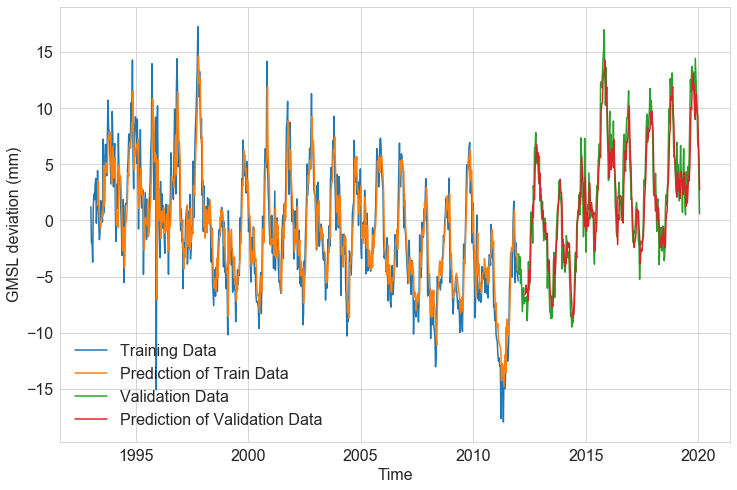

In [71]:
#plot for predicted values for train and validation data 
plt.figure(figsize=(12,8))
plt.plot(X_train , y_train , label = "Training Data")
plt.plot(X_train[len(theta):,] , X_pred[len(theta):,] , label = "Prediction of Train Data")
plt.plot(X_test , y_test , label = "Validation Data")
plt.plot(X_test[len(theta):,] , Y_pred[len(theta):,] , label = "Prediction of Validation Data")
plt.xlabel("Time")
plt.ylabel('GMSL deviation (mm)')
plt.legend(loc='lower left', frameon=False)
plt.show()

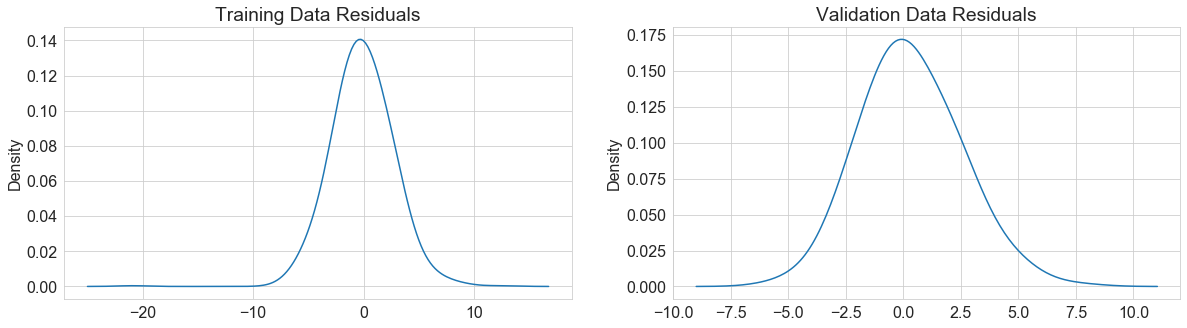

In [72]:
tr_residual = list((y_train-X_pred))
tes_residual = list((y_test - Y_pred))
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20,5))
sns.kdeplot(np.array(tr_residual), bw=0.5,ax=ax[0]).set_title("Training Data Residuals")
sns.kdeplot(np.array(tes_residual), bw=0.5,ax=ax[1]).set_title("Validation Data Residuals")
fig.show()

By looking at the plots above we can infer that the residuals are normally distribted around zero.

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

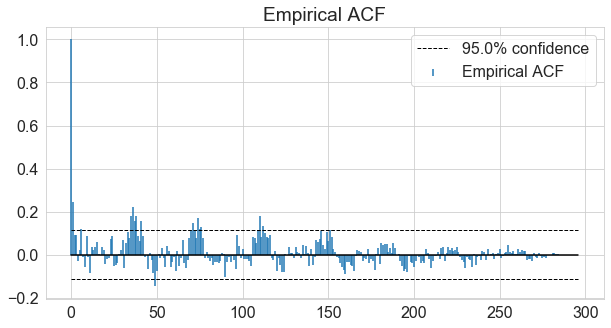

In [73]:
plt.figure(figsize=(10,5))
acfplot(tes_residual)
plt.grid(True)

As we know that the higher autocorrelation of the residuals refers to the fact that the model is incorrectly specifiesd. In the above shown **ACF** Pltot it is visible that the residuals autocorrelation values lies within the 95%-confidence bounds for the autocorrelation of a white noise sequence. From this we can infer that the residuals are white noise.


## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


In [74]:
p_range = list(range(2,151))
mseTrain = list()
mseTest = list()
for p in range(2,151):
  theta,Phi = fit_ar(y_train,p)
  pred_train,mse_train = predict_ar_1step(theta,np.array(y_train))
  mseTrain.append(mse_train)
  pred_test,mse_test = predict_ar_1step(theta,np.array(y_test))
  mseTest.append(mse_test)

In [75]:
ind = np.argmin(mseTest)
min_pt = p_range[ind]
min_error = mseTest[ind]
print(min_pt)

116


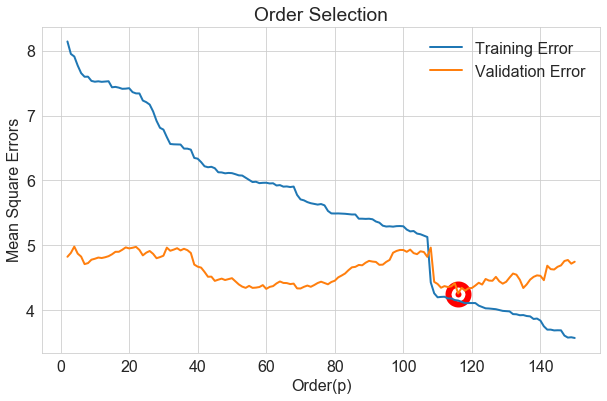

In [76]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(p_range, mseTrain, linewidth=2, label = 'Training Error')
ax.plot(p_range, mseTest, linewidth=2, label = 'Validation Error')
plt.scatter(min_pt, min_error,c ='red',linewidths=20)
plt.ylabel("Mean Square Errors")
plt.xlabel("Order(p)")
plt.title("Order Selection")
ax.legend(loc='upper right', frameon=False)
plt.grid(True)
plt.show()

**A8:**

**What is the main difference between the changes in training error and validation error as the order increases?**

We can see from the above plot that the mean square errors of the predictions on the training data is higher than the validation data before p= 100. Then it starts getting lower than the vaidation data mean square errors.

**Based on these results, which model order would you suggest to use and why?**

In the above plot it is visible that we are getting least Mean Square error on validation data when order of the autoregressive model is 116. But we can also see that there is a clear drop in MSE when order,p=60. Thus we will chose p=60 to reduce the complexity of model. That is we will use the 60 previous observations to predict the next observation.

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

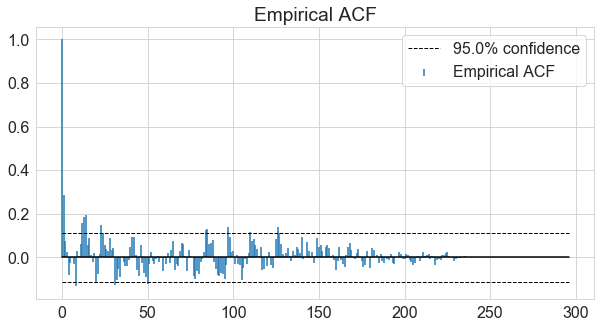

In [77]:
theta1,phi = fit_ar(y_train,p=60)
Y_pred,mse = predict_ar_1step(theta1,np.array(y_test, np.float64))
residuals1 = y_test-Y_pred
plt.figure(figsize=(10,5))
acfplot(residuals1)

**A9.** In the above shown **ACF** Plot it is visible that the residuals autocorrelation values are slightly smaller than the residuals autocorrelation values of the AR(10) model. Moreover, almost all the values lies within the 95%-confidence bounds for the autocorrelation of a white noise sequence. From this we can infer that the residuals are white noise.


## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [78]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """
    p = len(theta)
    n = len(y)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    theta = np.flip(theta.copy())
    for i in range(m):
      #y_sim[i] = np.transpose(theta).dot(phi)
      y_sim[i] = phi.dot(theta)
      phi = np.append(y_sim[i],phi[:len(phi)-1])   
    return y_sim

In [79]:
p = len(theta)
phi = np.flip(y_train[-p:].copy())

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

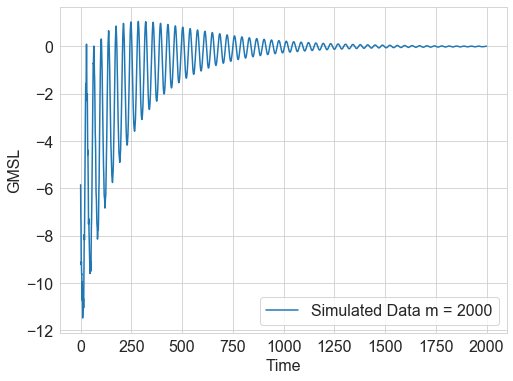

In [80]:
theta,Phi = fit_ar(y_train,60)
sim = simulate_ar( y_train ,theta , 2000)
plt.figure(figsize=(8,6))
plt.plot(range(2000) , sim , label = "Simulated Data m = 2000")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()
plt.show()

**A11:**  It is evident from the plot above that the predicted values for a large number of time steps (m=2000) eventually converges to a constant prediction of zero. 

Here we are using order p=60 that is only previuos 60 values are used to predict the next value and we are predicting $m$- step ahead predictions where $m=2000$. We know that the further ahead we forecast, the more uncertainty is associated with the forecast. As,

$$
\begin{aligned}
\hat y_{t+m|t} &= E[y_{t+m}|y_{1:t}]\\
&= \sum_{i=1}^pa_i \ E[y_{t+m-i}|y_{1:t}]
\end{aligned}
$$
Where, 
$$
\begin{aligned}
E[y_{t+m-i}|y_{1:t}] &= \begin{cases} 
      \hat y_{t+m-i} & i\geq m \\
      E[y_{t+m-i|y_{1:t}}] & i < m
   \end{cases}
\end{aligned}
$$
We can see from the above derivation that our model is using the expected value of the previously predicted values. If we predict way too far in the future as in our case say 2000-steps ahead in future our model would only predict white noise which is normally distributed around zero. That is why our simmulated values are converging to zero.

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [81]:
p = 60
# Number of training data points
n = y_train.shape[0]     

# Construct the regression matrix
Phi = np.zeros((n-p,p)) 
for i in range(p):
  Phi[:,i] = y_train.loc[i:n+i-p-1] 

# Drop the first p values from the target vector y
yy = y_train[p:]  # yy = (y_{t+p+1}, ..., y_n)

Phi2 = np.flip(y_train[-p:].copy())

#theta,Phi = fit_ar(y_train,p)
model = MLPRegressor(hidden_layer_sizes = (10,1))
model = model.fit(Phi,yy)
X_NAR_pred = model.predict(Phi)

n1 = y_test.shape[0]
Y_Phi = np.zeros((n1-p,p)) # <COMPLETE THIS LINE>
for i in range(p):
  Y_Phi[:,i] = y_test.loc[700+i:700+n1+i-p-1] # <COMPLETE THIS LINE>

Y_NAR_pred = model.predict(Y_Phi)

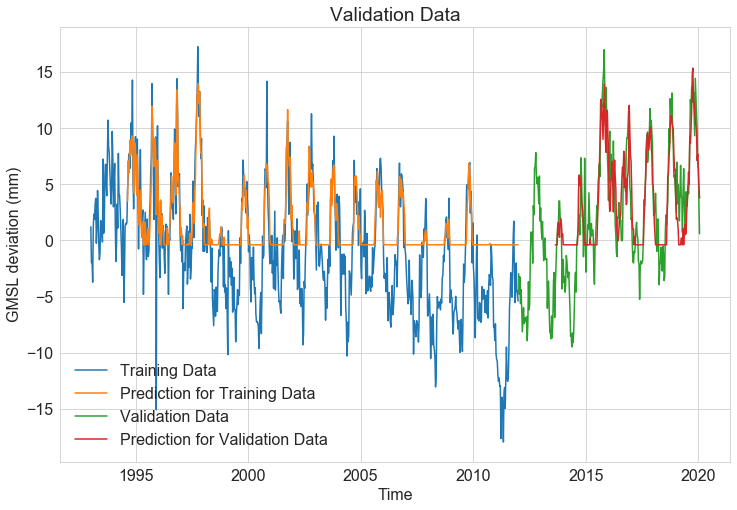

In [82]:
#plot for predicted values for train and validation data 
plt.figure(figsize=(12,8))
plt.plot(X_train , y_train , label = "Training Data")
plt.plot(X_train[p:,] , X_NAR_pred , label = "Prediction for Training Data")
plt.plot(X_test , y_test , label = "Validation Data")
plt.plot(X_test[p:,] , Y_NAR_pred , label = "Prediction for Validation Data")
plt.xlabel("Time")
plt.ylabel('GMSL deviation (mm)')
plt.title("Validation Data")
plt.legend(loc='lower left', frameon=False)
plt.show()

In [83]:
train_residual = X_NAR_pred -  y_train[p:]
test_residual = Y_NAR_pred - y_test[p:]

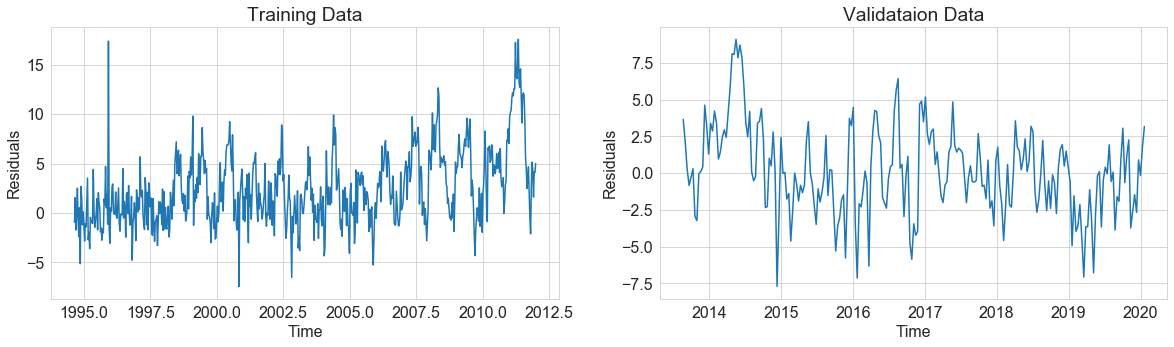

In [84]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(X_train[p:] , train_residual)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title('Training Data')

plt.subplot(1, 2, 2)
plt.plot(X_test[p:] , test_residual)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Validataion Data")
plt.show()

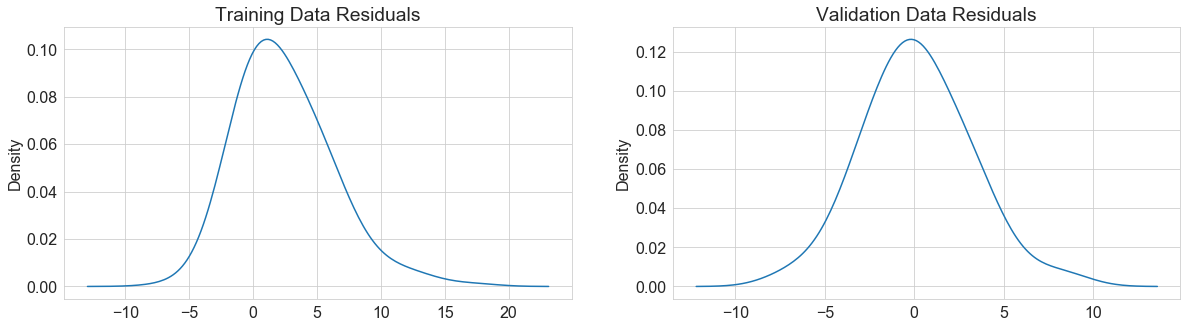

In [85]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20,5))
sns.kdeplot(np.array(train_residual), bw=0.5,ax=ax[0]).set_title("Training Data Residuals")
sns.kdeplot(np.array(test_residual), bw=0.5,ax=ax[1]).set_title("Validation Data Residuals")
fig.show()

**A12.** As we can see in the prediction plot that our predictions are not accturate with the seeting 1 hidden layer and 10 neurons. All the prediction are above zero only while we have actual values below zero as well. So we can say that our hyperparameters in the NAR model for the current data are not correct.

Relu activation function can considers either only the positive or negative part of its arguements. If we consider only one layer with the 10 neurons then the function will consider only one trend either positive or negative but if we give it 2 layers then one layer will handle the positive trend and the second layer will consider the negative trend.

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

In [86]:
#theta,Phi = fit_ar(y_train,p)
model = MLPRegressor(hidden_layer_sizes = (20,2),activation='tanh',max_iter=500,solver='lbfgs')
model = model.fit(Phi,yy)
tr_NAR_pred = model.predict(Phi)
tes_NAR_pred = model.predict(Y_Phi)

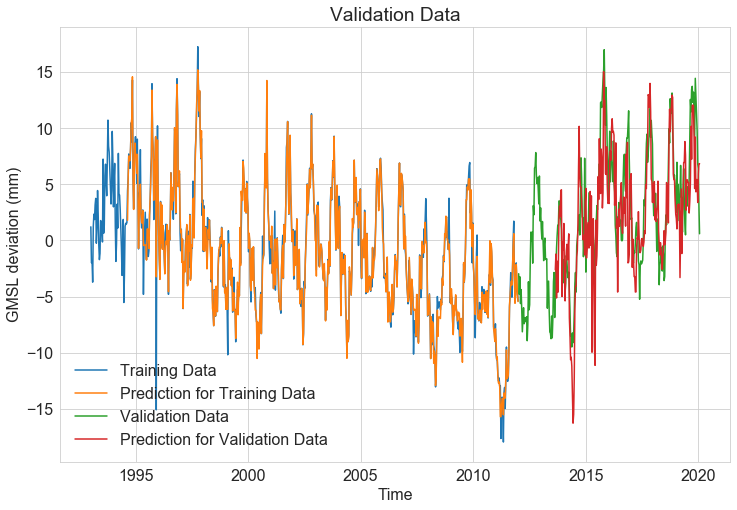

In [87]:
#plot for predicted values for train and validation data 
plt.figure(figsize=(12,8))
plt.plot(X_train , y_train , label = "Training Data")
plt.plot(X_train[p:,] , tr_NAR_pred , label = "Prediction for Training Data")
plt.plot(X_test , y_test , label = "Validation Data")
plt.plot(X_test[p:,] , tes_NAR_pred , label = "Prediction for Validation Data")
plt.xlabel("Time")
plt.ylabel('GMSL deviation (mm)')
plt.title("Validation Data")
plt.legend(loc='lower left', frameon=False)
plt.show()

In [88]:
train_residual = tr_NAR_pred -  y_train[p:]
test_residual = tes_NAR_pred - y_test[p:]

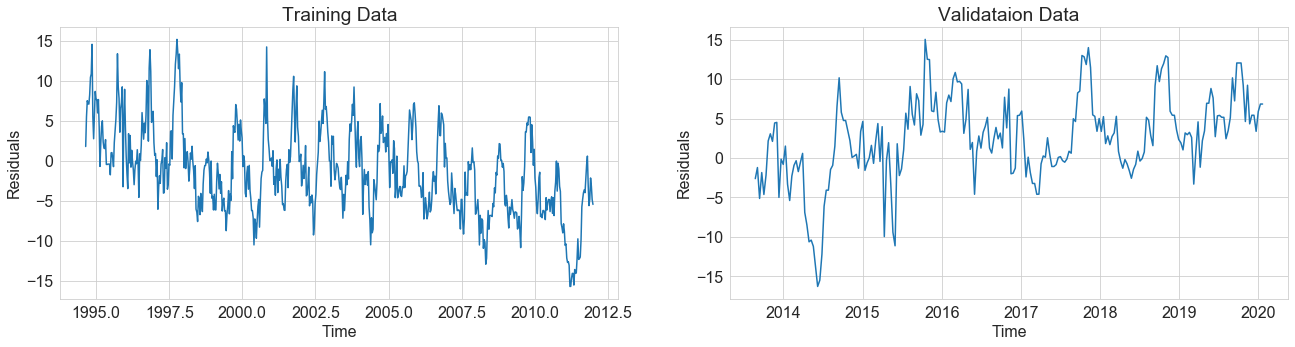

In [89]:
plt.figure(figsize=(22,5))
plt.subplot(1, 2, 1)
plt.plot(X_train[p:] , tr_NAR_pred)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title('Training Data')

plt.subplot(1, 2, 2)
plt.plot(X_test[p:] , tes_NAR_pred)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Validataion Data")
plt.show()

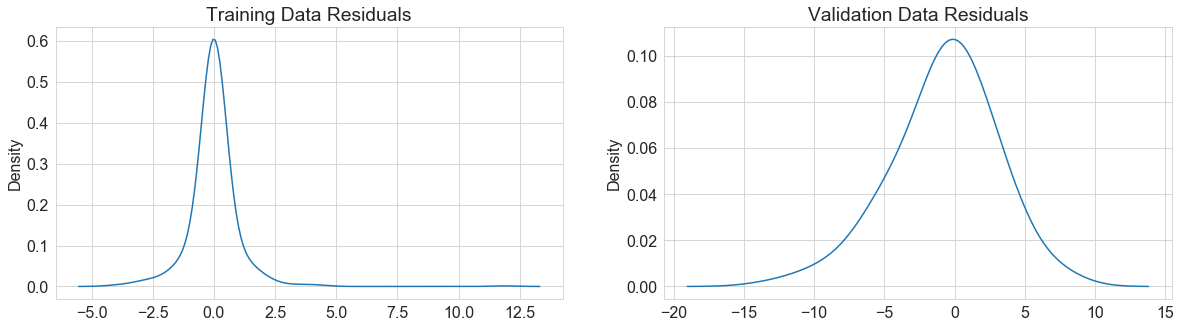

In [90]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20,5))
sns.kdeplot(np.array(train_residual), bw=0.5,ax=ax[0]).set_title("Training Data Residuals")
sns.kdeplot(np.array(test_residual), bw=0.5,ax=ax[1]).set_title("Validation Data Residuals")
fig.show()

**A13.** As we can see in the above prediction plot that our predictions are more accurate with the settings hidden_layer_sizes = (20,2), activation='tanh', max_iter=500, solver='lbfgs'. Now the model is predicting almost similar to the actual data. So we can say that our current selection for the hyperparameters in the NAR model is more appropriate. 

As we can see in the residuals plot that the training residuals are perfectly normally distributed but when we provide validation data to the model its residual are not completey normally distributted which means that our model is more sensitive to towards new data.